# Numerical example: MCMC from Type Ia Supernovae using the Metropolis-Hastings algorithm (Daniela Grandón, with inputs from Dragan Huterer and Joe Zuntz codes) 


Here we will use actual SNIa data from the JLA compilation [1] to constrain the matter and cosmological-constant energy densities $\Omega_M$ and $\Omega_\Lambda$ in a non-flat universe. To do that we will use MCMC and Metropolis-Hastings method.


In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # integration method
import corner

# figure size and resolution
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


### Step 1) Define your model and its dependence on the parameters $\theta$ you want to infer. In this example $\theta$={$\Omega_m$, $\Omega_{\Lambda}$, $M$}

We first define some cosmological functions, that define the "theory" in our likelihood

In [2]:
"The Hubble function. This equation comes solving the Einstein equations of General Relativity assuming the cosmological principle and the accelerated expansion (The famous FLRW metric)"

def dist_integrand(z, Om, Ok, w):
    Ol = 1 - Om - Ok
    return 1.0/np.sqrt(Om*(1+z)**3 + Ol*(1+z)**(3*(1+w)) + Ok*(1+z)**2)

SMALL = 1.0e-5  # some small number, doesn't matter what

# this is really H0 r(z)!
def rz(z, Om, Ok, w):
    chi = quad(dist_integrand, 0, z, args=(Om, Ok, w))[0]
    if (Ok > SMALL):
        return np.sinh(np.sqrt(Ok)*chi) / np.sqrt(Ok) # open
    elif (Ok < -SMALL):
        return np.sin(np.sqrt(-Ok)*chi) / np.sqrt(-Ok) # closed
    else:
        return chi

Remember the equation that relates the observed apparent magnitude $m$ and the cosmological parameters is

$m(z) = 5\log_{10} (H_0 d_L(z)) + \mathcal{M}$

In [26]:
## Luminosity distance

def dL(z, Om, Ol):
  Ok = 1-Om-Ol 
  w = -1.0  # dark energy equation of state, when w=-1 we have a cosmological constant.
  return (1+z)*rz(z, Om, Ok, w) # remember our rz is actually H0*r

#This is the important function, where Theta={Om, Ol, M}
def m_theory(z, Om, Ol, scriptM):
  return 5*np.log10(dL(z, Om, Ol)) + scriptM

### Step 2) Load the observed data  

dimensions of data and Cov are (31,) (31, 31)


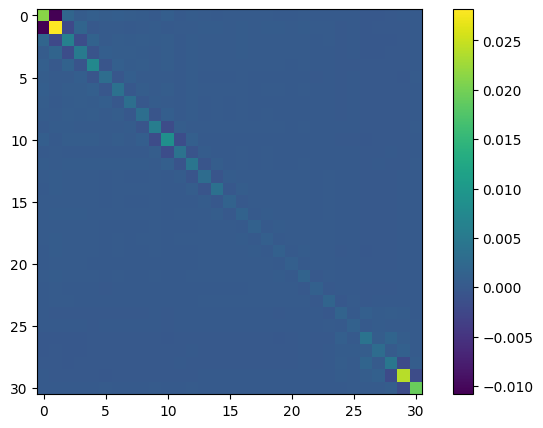

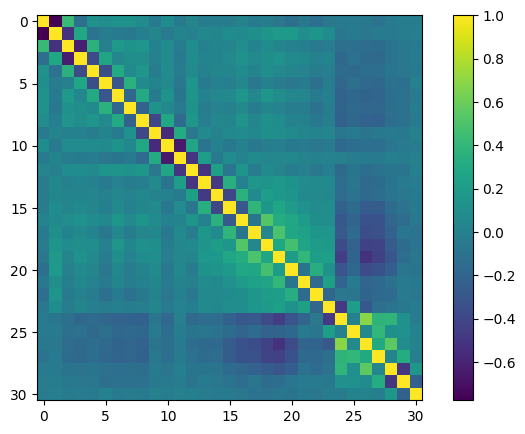

In [20]:
z_obs, m_obs = np.loadtxt("jla_mub.txt").T
C = np.loadtxt("jla_mub_covmax.txt")
C=C.reshape(31,31)
print('dimensions of data and Cov are', z_obs.shape, C.shape)

# we will need C^{-1} so take care of that right away

invC = np.linalg.inv(C)

# Always visualize your data and covariance matrix!

plt.imshow(C)
plt.colorbar()
plt.show()

plt.imshow(np.corrcoef(C))
plt.colorbar()
plt.show()


#### Now plot the data along with (diagonal) error bars, and overplot with some model that we think is probably a good fit, such as $\Omega_M=0.3, \Omega_\Lambda=0.7$, $\mathcal{M}=43.1$.  

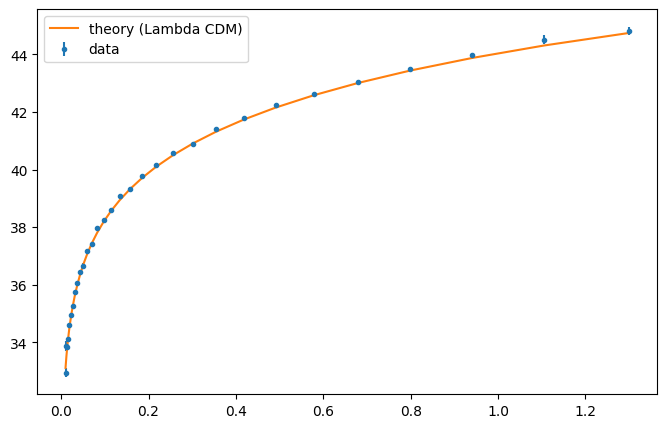

In [21]:
plt.errorbar(z_obs, m_obs, yerr=np.sqrt(np.diagonal(C)), marker='.', ls='',label='data')

mth_array = [m_theory(z, 0.3, 0.7, 43.1) for z in z_obs]

plt.plot(z_obs, mth_array,label='theory (Lambda CDM)')
plt.legend()
plt.show()

### Step 3) some checks: for example the $\chi^2$ metric

In [23]:
chisq = (m_obs - mth_array) @ invC @ (m_obs - mth_array)
print(chisq)

45.13380163901907


### Step 4) Define your likelihood and priors

In [30]:
def logposterior(p):
    Om, Ol, scriptM = p ### the parameters we want to infer
    if Om < 0 or Om>1: ### a way to include priors
        return -np.inf
    
    mth_array = [m_theory(z, Om, Ol, scriptM) for z in z_obs]
    d = m_obs - mth_array 
    lnL = -0.5 * d @ invC @ d 
    return lnL

### Step 5: Metropolis Hastings
Let's define the MH step. I use a multivariate Gaussian as the proposal distribution. I encourage you to play with the "step" size, which is the variance of the Gaussian. In this example I propose 0.0001, 0.0001, 0.0015 for $\Omega_m$, $\Omega_{\Lambda}$, $M$, respectively

In [31]:
#def propose(p):
#    return p + np.random.normal(size=p.size) * np.array([0.01, 0.01, 0.025])

def propose(p):
    return np.random.multivariate_normal(p,np.identity(3)*np.array([0.0001, 0.0001, 0.0015]))

In [32]:
print(propose(np.array([0.3, 0.7, 43.2]))) ## check a proposed step

[ 0.28543626  0.70940635 43.2719266 ]


And now the actual sampling algorithm

In [34]:
# First make an array describing the starting point of the iteration
p = np.array([0.3, 0.7, 43.2])
Lp = logposterior(p) ## the posterior for the starting point

# number of steps, plus define couple of arrays to store information during the sampling
N = 20000   # number of total attempts to walk
chain = np.zeros((N, 3))
likes = np.zeros(N)

# start the array of weights; make it 1 element long and append below
weights = [0]
param_corresp_weight= np.array([[0, 0, 0]])  # just initializing, had to declare first dummy one

##################
# Main MCMC loop
##################

acc=0

for i in range(N):
    if i%1000 == 0:  # print every 1000th step or something
        print(i)
    
    # new possible point and its likelihood
    q = propose(p)
    Lq = logposterior(q)
    ##################################
    # Metropolis acceptance criterion
    ### if accepted:
    ##################################    
    if (Lq > Lp) or Lq - Lp > np.log(np.random.uniform()):
        p = q
        Lp = Lq
        # count accepts
        acc += 1
        ##################################
        ### computing the "weight"
        ##################################
        # add (append) weight array element for new model and set it to one
        weights.append(1)
        # and write corresponding parameter values
        param_corresp_weight = np.vstack([param_corresp_weight, p])
    ##################################
    ### if rejected:
    ##################################    
    else: # if rejected, increase weight by one
      index = len(weights)-1
      weights[index] += 1

    # store next point, whether it's the same or not
    chain[i] = p
    # store the log likelihood
    likes[i] = Lp

# Done. Print acceptance fraction
print('Acceptance rate is', acc/N)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
Acceptance rate is 0.44905


#### Visualize your chains

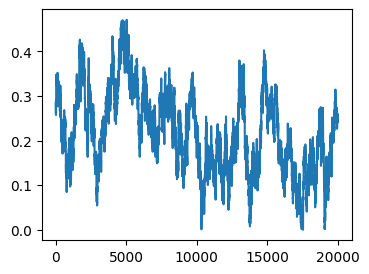

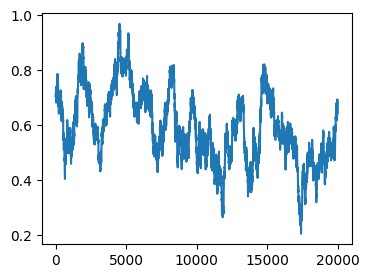

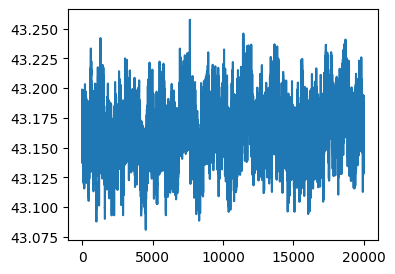

In [35]:
for i in range(3):
    plt.figure(figsize=(4,3))
    plt.plot(chain[:,i])

In [36]:
#plt.plot(chain[2000:,-1])


Text(0.5, 0, '$\\Omega_\\Lambda$')

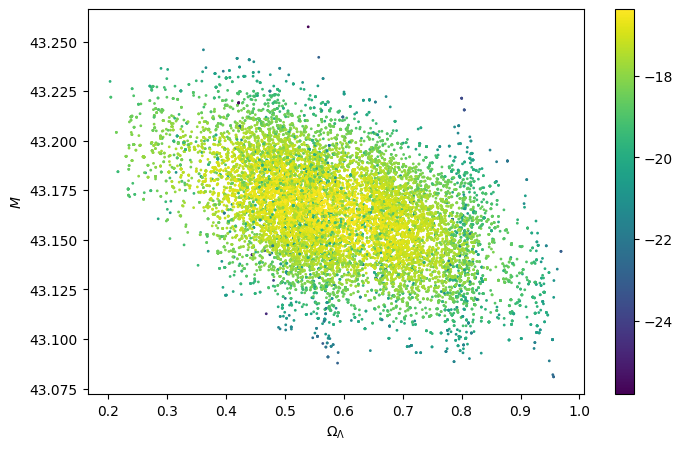

In [37]:
plt.scatter(chain[:,1], chain[:,2], s=1, c=likes[:])
plt.colorbar()
plt.ylabel("$M$")
plt.xlabel("$\Omega_\Lambda$")

Text(0, 0.5, '$\\Omega_\\Lambda$')

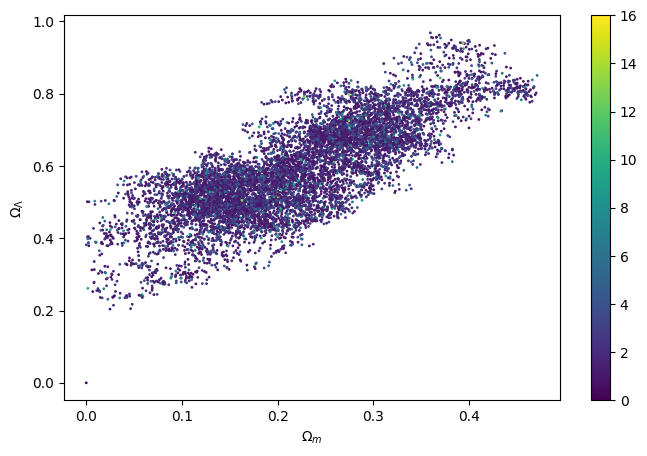

In [38]:

plt.scatter(param_corresp_weight[:,0], param_corresp_weight[:,1], s=1, c=weights[:])
plt.colorbar()
plt.xlabel("$\Omega_m$")
plt.ylabel("$\Omega_\Lambda$")

### Step 6) We use "corner" to obtain the posterior distributions in 2D and the marginal distribution of each parameter

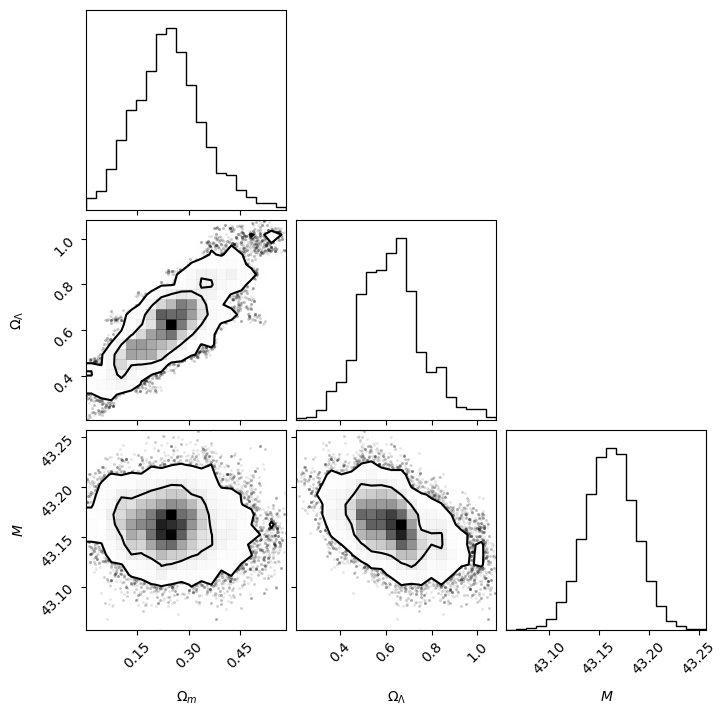

In [17]:
labels = [r"$\Omega_m$","$\Omega_\Lambda$",r"$M$"]
fig = corner.corner(chain,labels=labels,levels=(0.68,0.95))
plt.show()

### Homework: 1) Please change the step size in the MH algorithm. 2) Check the results for a different starting point

### References
[1] Betoule et al. 2014 https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract